<a href="https://www.kaggle.com/code/amirsher/cnn-digit-recognizer-using-boosted-lenet5?scriptVersionId=216572258" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Digit Recognizer using LeNet-5 with improvements

In this notebook I will use [LeNet-5](https://en.wikipedia.org/wiki/LeNet) digit recognizer model.

1. First I will implement the basic [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-95a.pdf) which was proposed by Yann LeCun et al. in 1989.
2. Second, I will add some improvements by replacing tanh with ReLu activation and using dropout regularization (I later removed dropout and put BatchNormalization).
3. Third, I will use augmentation to add some more random samples based on the provided samples, to add more generalization, and also because the boosting requires a lot of data.
3. Fourth, I will use a boosting technique with LeNet5. There is a lot of literature about boosted LeNet4 and I've never seen boosted LeNet5 in papers or implementations, so I was curious to implement it by myself.

Note that I only used the provided kaggle dataset, which is a partial MNIST database (with the test list being the other unprovided MNIST part). 
Many submitted results use the entire MNIST database for training, which I consider cheating, and less challenging. I prefer the challenge.


In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Read and prepare the input data

In [2]:
# Read data from files

train_pd = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_pd = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Extract the labels from the dataframe
label_nums = train_pd["label"]
label = to_categorical(label_nums, num_classes = 10)

# Extract and normalize the data 
train = train_pd.drop(labels = ["label"],axis = 1) / 255.0
test = test_pd / 255.0

# Reshape the data
(rows, cols, channels) = (28,28,1)

def ReShape (DF, rows, cols, channels):
    return DF.values.reshape(DF.shape[0],rows,cols,channels)

train = ReShape (train, rows, cols, channels)
test = ReShape (test, rows, cols, channels)

# Build training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(train,label, test_size = 0.1)

print ("X_train shape:" , X_train.shape, "  Y_train shape:", Y_train.shape)
print ("X_val shape:", X_val.shape, "  Y_val shape:", Y_val.shape)
print ("test shape:", test.shape)

X_train shape: (37800, 28, 28, 1)   Y_train shape: (37800, 10)
X_val shape: (4200, 28, 28, 1)   Y_val shape: (4200, 10)
test shape: (28000, 28, 28, 1)


## Show some input samples

In [4]:
# Plotting examples of training data

import matplotlib.pyplot as plt
from collections import defaultdict
from random import sample

def plot_digits(x,y,num_rows=10, start_range=0):
    figw, figh = 12.0, 12.0

    fig, axes = plt.subplots(num_rows, 10, figsize=(figw, figh))
    plt.subplots_adjust(wspace = 0.2/figw, hspace = 0.2/figh )

    counter = defaultdict(int)

    for i in sample(range(start_range,len(x)), 1000):
        label = np.argmax(y[i])
        if counter[label] >= num_rows: continue
        img = x[i].reshape((rows,cols))
        axes[counter[label], label].imshow(img, cmap='Greys')
        axes[0, label].set_title(label)
        counter[label] += 1

    [ax.set_axis_off() for ax in axes.ravel()]
    plt.show()

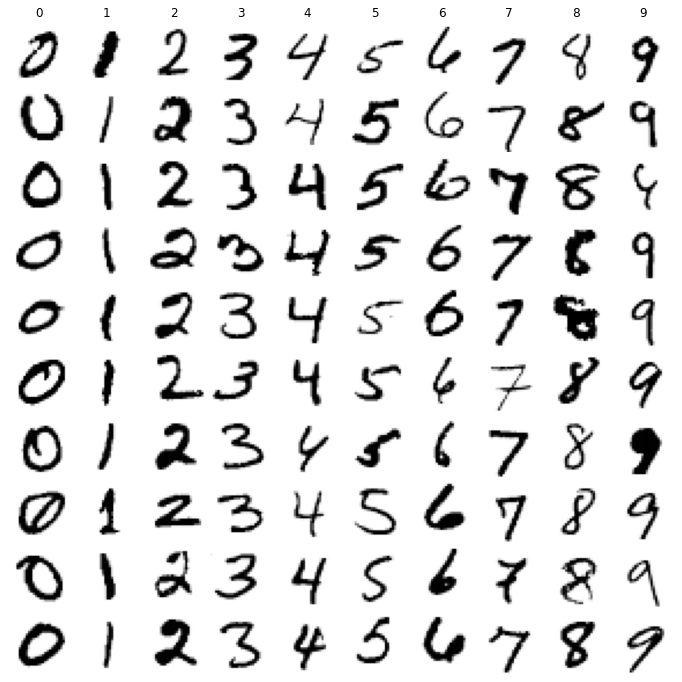

In [5]:
# Plot random digits from the training dataset
plot_digits(X_train,Y_train)

# Build LeNet-5 CNN models

In [6]:
# Read keras libraries

from keras.layers import Activation,Dropout,Dense,Conv2D,AveragePooling2D,MaxPooling2D,Flatten,ZeroPadding2D,BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping

#from tensorflow.keras import Model



## LeNet-5

In [7]:
# LeNet-5 model
class LeNet5(Sequential):
    def __init__(self, input_shape=(rows, cols, channels),activation='tanh',pooling='avg',dropout = 0, name="Base"):
        super().__init__(name='LeNet5_'+name)
        self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation=activation, input_shape=input_shape, padding="same"))
        if pooling == 'avg':
            self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        else:
            self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation=activation, padding='valid'))
        if pooling == 'avg':
            self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        else:
            self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        if dropout > 0:
            self.add((Dropout(rate = dropout)))
        self.add(Flatten())
        self.add(Dense(120, activation=activation))
        self.add(Dense(84, activation=activation))
        self.add(Dense(10, activation='softmax'))

        self.compile(optimizer='adam',
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])
        


# LeNet-5 improved model with BatchNormalization
class LeNet5BN(Sequential):
    def __init__(self, input_shape=(rows, cols, channels), name="ImprovedBN"):
        super().__init__(name='LeNet5_'+name)
        self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), input_shape=input_shape, padding="same"))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), padding='valid'))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Flatten())
        self.add(Dense(120))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(Dense(84))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(Dense(10, activation='softmax'))

        self.compile(optimizer='adam',
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])

In [8]:
model_LeNet5_base = LeNet5()
model_LeNet5_base.summary()

Model: "LeNet5_Base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                

In [9]:
# Train the model
early_stop = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
model_LeNet5_base.fit(X_train, y=Y_train, 
                      epochs=25, batch_size=128, 
                      validation_data=(X_val, Y_val),
                      callbacks=[early_stop])

Epoch 1/25
296/296 [==============================] - 1s 3ms/step - loss: 0.4289 - accuracy: 0.8739 - val_loss: 0.2218 - val_accuracy: 0.9390
Epoch 2/25
296/296 [==============================] - 1s 3ms/step - loss: 0.1604 - accuracy: 0.9513 - val_loss: 0.1398 - val_accuracy: 0.9619
Epoch 3/25
296/296 [==============================] - 1s 3ms/step - loss: 0.1081 - accuracy: 0.9677 - val_loss: 0.1116 - val_accuracy: 0.9683
Epoch 4/25
296/296 [==============================] - 1s 3ms/step - loss: 0.0805 - accuracy: 0.9753 - val_loss: 0.0973 - val_accuracy: 0.9690
Epoch 5/25
296/296 [==============================] - 1s 3ms/step - loss: 0.0636 - accuracy: 0.9803 - val_loss: 0.0963 - val_accuracy: 0.9705
Epoch 6/25
296/296 [==============================] - 1s 3ms/step - loss: 0.0496 - accuracy: 0.9851 - val_loss: 0.0899 - val_accuracy: 0.9717
Epoch 7/25
296/296 [==============================] - 1s 3ms/step - loss: 0.0409 - accuracy: 0.9871 - val_loss: 0.0790 - val_accuracy: 0.9757
Epoch 

In [10]:
preds1 = model_LeNet5_base.evaluate(x = X_val, y = Y_val)
print ("Loss = " + str(preds1[0]))
print ("Val Accuracy = " + str(preds1[1]))

132/132 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9824
Loss = 0.07251183688640594
Val Accuracy = 0.9823809266090393


## Improved LeNet-5 model
I improved the basic model by:
1. Replacing tanh activation function with Rectified Linear Unit - ReLu.
2. Used max pooling instead of average.
3. Used dropout for more generalization (especially important since the database is partial).
4. Used also a model with BatchNormalization.

In [11]:
#model_LeNet5 = LeNet5(activation='relu',pooling='max',dropout = 0.2, name="Improved")
model_LeNet5 = LeNet5BN(name="Improved_BN")
model_LeNet5.summary()

Model: "LeNet5_Improved_BN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10, 16) 

In [12]:
early_stop = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
model_LeNet5.fit(X_train, y=Y_train, 
                    epochs=25, batch_size=128, 
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stop])

Epoch 1/25
296/296 [==============================] - 1s 4ms/step - loss: 0.2468 - accuracy: 0.9349 - val_loss: 0.3041 - val_accuracy: 0.9233
Epoch 2/25
296/296 [==============================] - 1s 4ms/step - loss: 0.0587 - accuracy: 0.9828 - val_loss: 0.0769 - val_accuracy: 0.9776
Epoch 3/25
296/296 [==============================] - 1s 4ms/step - loss: 0.0363 - accuracy: 0.9896 - val_loss: 0.0892 - val_accuracy: 0.9736
Epoch 4/25
296/296 [==============================] - 1s 4ms/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.0564 - val_accuracy: 0.9826
Epoch 5/25
296/296 [==============================] - 1s 4ms/step - loss: 0.0187 - accuracy: 0.9947 - val_loss: 0.0572 - val_accuracy: 0.9831
Epoch 6/25
296/296 [==============================] - 1s 4ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0509 - val_accuracy: 0.9838
Epoch 7/25
296/296 [==============================] - 1s 4ms/step - loss: 0.0109 - accuracy: 0.9968 - val_loss: 0.0531 - val_accuracy: 0.9838
Epoch 

In [13]:
preds2 = model_LeNet5.evaluate(x = X_val, y = Y_val)
print ("Loss = " + str(preds2[0]))
print ("Val Accuracy = " + str(preds2[1]))

132/132 [==============================] - 0s 2ms/step - loss: 0.0528 - accuracy: 0.9871
Loss = 0.05281089246273041
Val Accuracy = 0.9871428608894348


We can see some improvements in the model accuracy compared to the basic model.

### Analyze LeNet-5 results

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt

# Plot Confusion Matrix and classification errors

def analyze_results(model_name, y_pred, y_true, x):

    conf_mat = confusion_matrix(y_true, y_pred, normalize=None)
    class_report = classification_report(y_true, y_pred)
    
    # Plot the confusion matrix
    
    fig, ax = plt.subplots(figsize=(11, 9))
    im = ax.imshow(conf_mat, cmap="OrRd")

    # We want to show all ticks...
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    # ... and label them with the respective list entries
    ax.set_xticklabels(np.arange(10))
    ax.set_yticklabels(np.arange(10))

    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            num_ij = int(conf_mat[i, j])
            text_c = "w" if num_ij > conf_mat.mean() else "b"
            #text_s = str(int(num_ij)) if (num_ij==0) or (num_ij==1) else "%.3f" % num_ij
            text = ax.text(j, i, num_ij, ha="center", va="center", color=text_c)

    ax.set_title(f"Confusion Matrix for model {model_name}")
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    
    fig.tight_layout()
    plt.show()
    
    print (class_report)
    
    # Gather all the missed predictions for further analysis
    faults = []
    for i,label in enumerate(y_true):
        if label != y_pred[i]:
            fault = {'label': label, 'pred': y_pred[i], 'idx': i,'img': x[i].reshape((28,28))}
            faults.append(fault)
    
    accuracy = (len(y_true) - len(faults)) / len(y_true)
    print (f"Accuracy for model {model_name}: {accuracy}")
    
    return conf_mat, class_report, accuracy, faults


def analyze_model(model, x, y):
    predicts = model.predict(x,batch_size=None, verbose=0)
    y_pred = np.argmax(predicts, axis=1)
    y_true = np.argmax(y, axis=1)
    conf_mat, class_report, accuracy, faults = analyze_results(model.name, y_pred, y_true, x)
    return conf_mat, class_report, accuracy, faults


# Draw images of faults
def show_faults(faults):
    figw, figh = 16.0, 14.0

    max_faults = 11
    fig, axes = plt.subplots(10,max_faults, squeeze = False, figsize=(figw, figh))

    counter = defaultdict(int)

    for fault in faults:
        label = fault['label']
        pred = fault['pred']
        img = fault['img']
        if counter[label] >= max_faults: continue
        axes[label, counter[label]].imshow(img, cmap='Greys')
        axes[label, counter[label]].set_title(str(label)+'. pred'+str(pred))
        counter[label] += 1

    [ax.set_axis_off() for ax in axes.ravel()]
    plt.show()

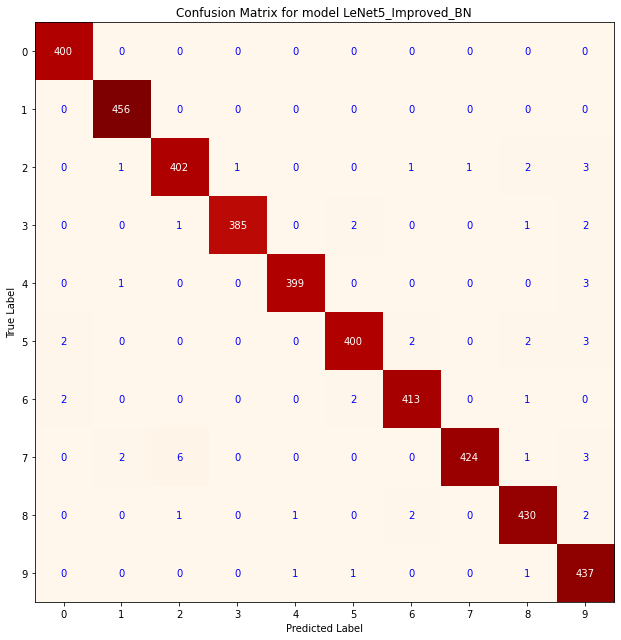

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       0.99      1.00      1.00       456
           2       0.98      0.98      0.98       411
           3       1.00      0.98      0.99       391
           4       1.00      0.99      0.99       403
           5       0.99      0.98      0.98       409
           6       0.99      0.99      0.99       418
           7       1.00      0.97      0.98       436
           8       0.98      0.99      0.98       436
           9       0.96      0.99      0.98       440

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200

Accuracy for model LeNet5_Improved_BN: 0.9871428571428571


In [15]:
conf_mat, class_report, accuracy, faults = analyze_model(model_LeNet5, X_val, Y_val)

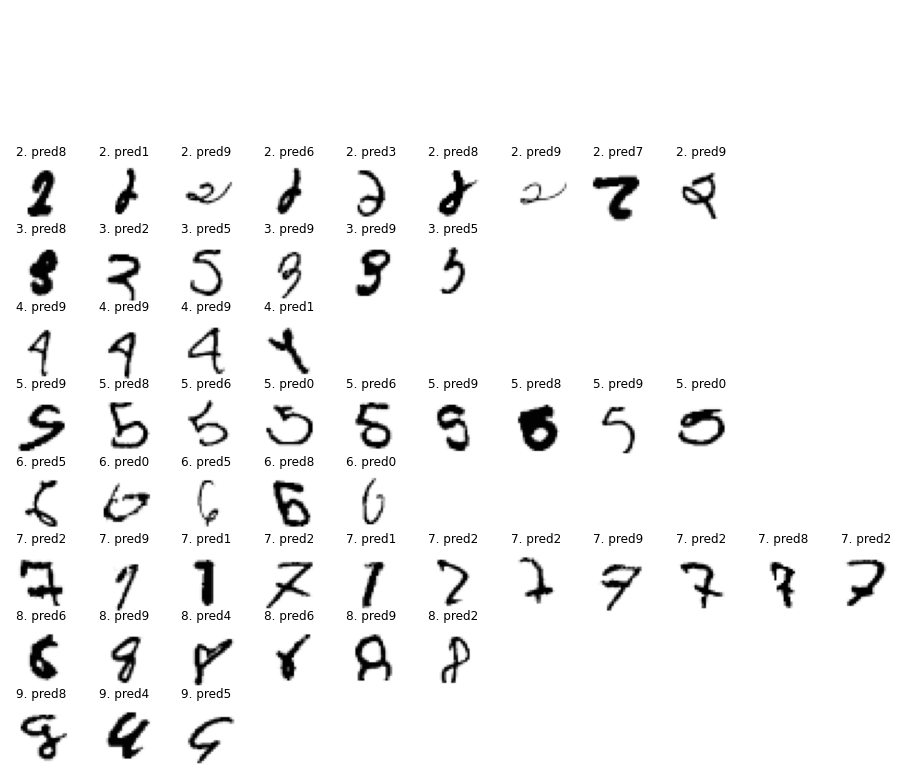

In [16]:
# Print the digits with wrong predictions
show_faults(faults)

Some of the faults are really hard to recognise even for a human. Other faults might be due to a too small training set (the training set in the challenge is smaller than the full MNIST database, and I don't want to cheat using the full MNIST).
I'll address this issue using augmented data.

## Data Augmentation
I will add more samples to the training dataset by making random changes to the provided dataset.

Note that using augmented data is not as good as fresh new data, especially in CNN, but I need more samples for boosting and it's better than nothing.
I only used some roation, width shift, shear and zoom. I can't apply too many changes (such as flipping, or 180 rotation) because the shape would not be a digit anymore, or would become another digit (9 can turn into 6 but the label remains '9').

In [17]:

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.1,
                            data_format="channels_last")


In [18]:
# Generate new augmented samples offline

X_train_aug = X_train
Y_train_aug = Y_train
print ("Original train size: " , X_train_aug.shape)

target_size = 32200 # Add new samples to the current 37800 training samples
batch_size = 200

digits_gen = datagen.flow(X_train, Y_train, batch_size=batch_size)

for i in range(target_size//batch_size):   
    batch = digits_gen.next()
    X_train_aug = np.append(X_train_aug, batch[0], axis=0)
    Y_train_aug = np.append(Y_train_aug, batch[1], axis=0)

print ("Augmented train size: " , X_train_aug.shape)


Original train size:  (37800, 28, 28, 1)
Augmented train size:  (70000, 28, 28, 1)


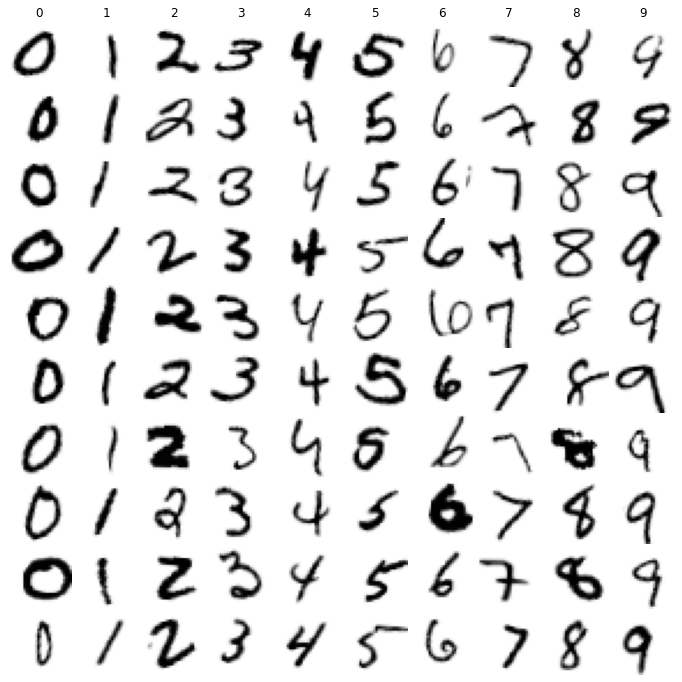

In [19]:
# Plot some new samples

plot_digits(X_train_aug, Y_train_aug, start_range=40000)

In [20]:
# model_LeNet5_aug = LeNet5(activation='relu',pooling='max',dropout = 0.2, name="Augmented")
model_LeNet5_aug = LeNet5BN(name="Augmented_BN")

In [21]:
# Train the model with the augmented dataset

early_stop = EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)
batch_size = 128

model_LeNet5_aug.fit (X_train_aug, Y_train_aug, batch_size=batch_size,
                       epochs=100,
                       validation_data=(X_val, Y_val),
                       callbacks=[early_stop])


Epoch 1/100
547/547 [==============================] - 2s 4ms/step - loss: 0.2151 - accuracy: 0.9403 - val_loss: 0.0671 - val_accuracy: 0.9800
Epoch 2/100
547/547 [==============================] - 2s 4ms/step - loss: 0.0618 - accuracy: 0.9814 - val_loss: 0.0655 - val_accuracy: 0.9800
Epoch 3/100
547/547 [==============================] - 2s 4ms/step - loss: 0.0410 - accuracy: 0.9876 - val_loss: 0.0633 - val_accuracy: 0.9807
Epoch 4/100
547/547 [==============================] - 2s 4ms/step - loss: 0.0317 - accuracy: 0.9899 - val_loss: 0.0616 - val_accuracy: 0.9800
Epoch 5/100
547/547 [==============================] - 2s 4ms/step - loss: 0.0249 - accuracy: 0.9923 - val_loss: 0.0544 - val_accuracy: 0.9836
Epoch 6/100
547/547 [==============================] - 2s 4ms/step - loss: 0.0200 - accuracy: 0.9935 - val_loss: 0.0628 - val_accuracy: 0.9829
Epoch 7/100
547/547 [==============================] - 2s 4ms/step - loss: 0.0163 - accuracy: 0.9947 - val_loss: 0.0496 - val_accuracy: 0.9869

In [22]:
preds3 = model_LeNet5_aug.evaluate(x = X_val, y = Y_val)
print ("Loss = " + str(preds3[0]))
print ("Val Accuracy = " + str(preds3[1]))

132/132 [==============================] - 0s 2ms/step - loss: 0.0544 - accuracy: 0.9876
Loss = 0.05437195301055908
Val Accuracy = 0.9876190423965454


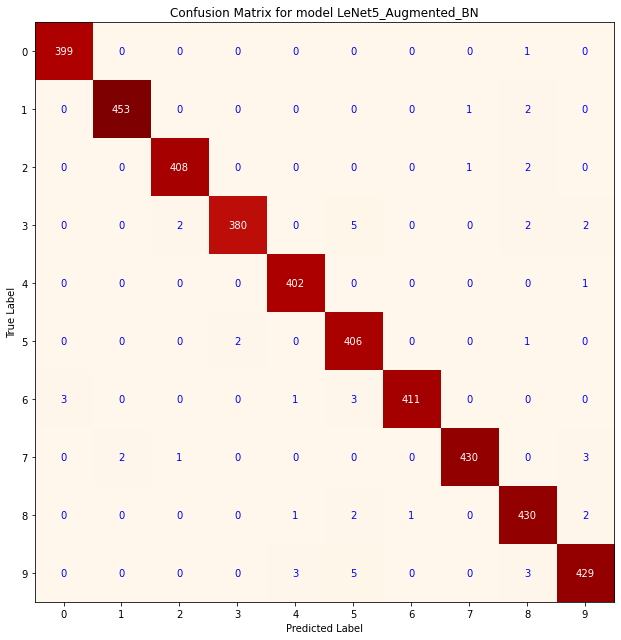

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      0.99      0.99       456
           2       0.99      0.99      0.99       411
           3       0.99      0.97      0.98       391
           4       0.99      1.00      0.99       403
           5       0.96      0.99      0.98       409
           6       1.00      0.98      0.99       418
           7       1.00      0.99      0.99       436
           8       0.98      0.99      0.98       436
           9       0.98      0.97      0.98       440

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200

Accuracy for model LeNet5_Augmented_BN: 0.9876190476190476


In [23]:
conf_mat, class_report, accuracy, faults  = analyze_model(model_LeNet5_aug, X_val, Y_val)

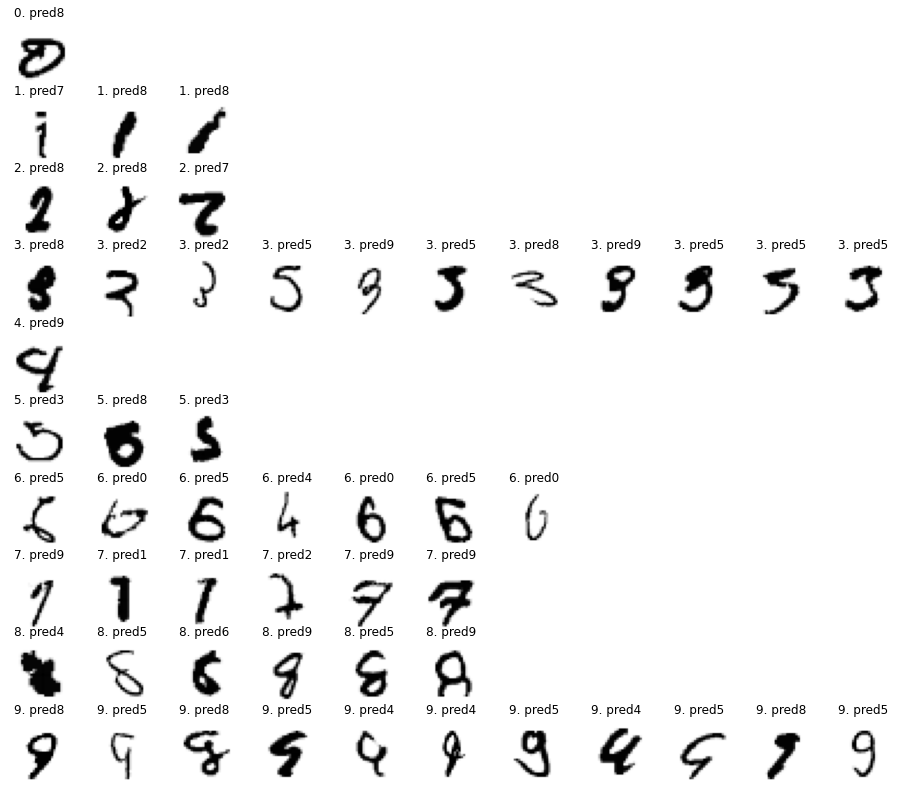

In [24]:
show_faults(faults)

Ussually I get better results with the augmented data (but not always).

Now I'll try to improve results with boosted LeNet-5...

## Boosted LeNet-5
Based on the idea of boosted LeNet-4... I haven't seen it implemented with LeNet-5.

For boosted LeNet we need a lot of data.
I will use the augmented training data and produce 3 datasets for training 3 LeNet-5 networks:
1. Net1: Train with augmented data
2. Net2: Train with data consists of: 50% - all errors from Net1. 50% - data without errors.
3. Net3: Train with data consists of all data that gave different predictions from Net1 and Net2.

The result prediction will be the sum of all softmax predictions.

In [25]:
# Build a new training set for network 2 from previous model based on success and failed samples

y_pred = model_LeNet5_aug.predict(X_train_aug,batch_size=None, verbose=0)

mask = np.argmax(Y_train_aug, axis=1) == np.argmax(y_pred, axis=1)
x_hit = X_train_aug[mask]
y_hit = Y_train_aug[mask]
x_miss = X_train_aug[~mask]
y_miss = Y_train_aug[~mask]

num_misses = y_miss.shape[0]
sample_idx = sample(range(y_hit.shape[0]), y_miss.shape[0])  # random index samples from hits in the same amount of misses
x_hit_reduced = x_hit[sample_idx] # choose random samples of hits with the same number of samples as misses
y_hit_reduced = y_hit[sample_idx]

# Create new training samples for network 2 with shuffled hit and miss samples
X_train2 = np.append(x_miss,x_hit_reduced, axis=0)
Y_train2 = np.append(y_miss,y_hit_reduced, axis=0)
idx_shuffle = list(range(X_train2.shape[0]))
np.random.shuffle(idx_shuffle)
X_train2 = X_train2[idx_shuffle]
Y_train2 = Y_train2[idx_shuffle]


In [26]:
# Execute LeNet network 2

# model_LeNet5_2 = LeNet5(activation='relu',pooling='max',dropout = 0.2, name="Net2")
model_LeNet5_2 = LeNet5BN(name="Net2")

In [27]:
# Train network 2

early_stop = EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)
batch_size = 128

model_LeNet5_2.fit (X_train2, Y_train2, 
                       epochs=100,
                       callbacks=[early_stop])



Epoch 1/100
8/8 [==============================] - 0s 5ms/step - loss: 2.3987 - accuracy: 0.1926
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 1.2858 - accuracy: 0.6762
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 0.8558 - accuracy: 0.8279
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.8811
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 0.4634 - accuracy: 0.9385
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 0.3764 - accuracy: 0.9426
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2955 - accuracy: 0.9631
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2516 - accuracy: 0.9754
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1906 - accuracy: 0.9959
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 0.1700 - accuracy: 0.9959
Epoch 11/100
8/8 [===========

In [28]:
# Build a new training set for network 3 based on differences between network 1 and network 2

y_pred1 = model_LeNet5_aug.predict(X_train_aug, batch_size=None, verbose=0)
y_pred2 = model_LeNet5_2.predict(X_train_aug, batch_size=None, verbose=0)

mask = np.argmax(y_pred1, axis=1) == np.argmax(y_pred2, axis=1)
X_train3 = X_train_aug[~mask] # Network3 train on samples with different predictions
Y_train3 = Y_train_aug[~mask]

In [29]:
# Execute LeNet network 3

# model_LeNet5_3 = LeNet5(activation='relu',pooling='max',dropout = 0.2, name="Net3")
model_LeNet5_3 = LeNet5BN(name="Net3")

In [30]:
# Train network 3
early_stop = EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)
batch_size = 128

model_LeNet5_3.fit (X_train3, Y_train3, 
                       epochs=100,
                       callbacks=[early_stop])

Epoch 1/100
1194/1194 [==============================] - 4s 3ms/step - loss: 0.2917 - accuracy: 0.9135
Epoch 2/100
1194/1194 [==============================] - 4s 3ms/step - loss: 0.1048 - accuracy: 0.9664
Epoch 3/100
1194/1194 [==============================] - 4s 3ms/step - loss: 0.0767 - accuracy: 0.9757
Epoch 4/100
1194/1194 [==============================] - 4s 3ms/step - loss: 0.0594 - accuracy: 0.9808
Epoch 5/100
1194/1194 [==============================] - 4s 3ms/step - loss: 0.0510 - accuracy: 0.9831
Epoch 6/100
1194/1194 [==============================] - 4s 3ms/step - loss: 0.0435 - accuracy: 0.9857
Epoch 7/100
1194/1194 [==============================] - 4s 3ms/step - loss: 0.0352 - accuracy: 0.9886
Epoch 8/100
1194/1194 [==============================] - 4s 3ms/step - loss: 0.0339 - accuracy: 0.9889
Epoch 9/100
1194/1194 [==============================] - 4s 3ms/step - loss: 0.0288 - accuracy: 0.9896
Epoch 10/100
1194/1194 [==============================] - 4s 3ms/step - l

In [31]:
# Get prediction result based on the sum of the 3 LeNet5 networks

def boosted_lenet5 (x):
    pred1 = model_LeNet5_aug.predict(x,batch_size=None, verbose=0)
    pred2 = model_LeNet5_2.predict(x,batch_size=None, verbose=0)
    pred3 = model_LeNet5_3.predict(x,batch_size=None, verbose=0)

    final_pred = np.argmax(pred1+pred2+pred3, axis = 1)
    return final_pred

In [32]:
# Testing validation set on boosted model

final_pred = boosted_lenet5(X_val)

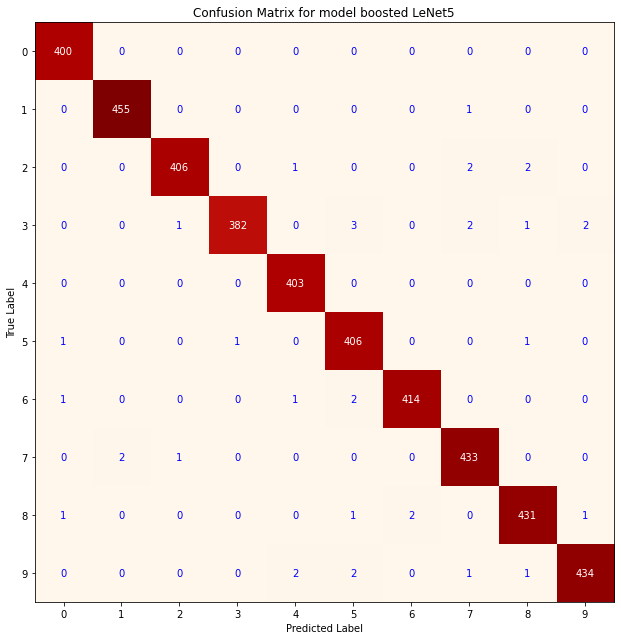

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       400
           1       1.00      1.00      1.00       456
           2       1.00      0.99      0.99       411
           3       1.00      0.98      0.99       391
           4       0.99      1.00      1.00       403
           5       0.98      0.99      0.99       409
           6       1.00      0.99      0.99       418
           7       0.99      0.99      0.99       436
           8       0.99      0.99      0.99       436
           9       0.99      0.99      0.99       440

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200

Accuracy for model boosted LeNet5: 0.9914285714285714


In [33]:
# Analyze results

conf_mat, class_report, accuracy, faults = analyze_results("boosted LeNet5", final_pred, np.argmax(Y_val, axis=1), X_val)



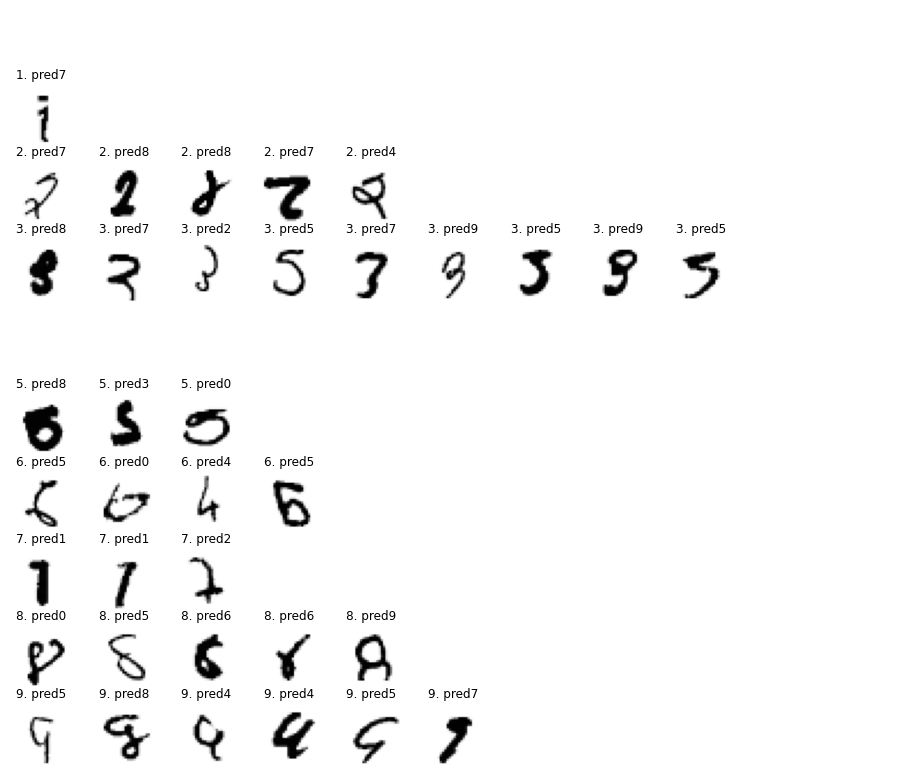

In [34]:
# Show the errors

show_faults(faults)

# Summery

In [35]:
# Build Results table
acc = [preds1[1], preds2[1], preds3[1], accuracy]
models = ['LeNet5 Base', 'Improved', 'Augmented', 'Boosted LeNet5']
tbl = {"Model": models, "Accuracies": acc}
tbl_df = pd.DataFrame(tbl)
tbl_df

,Model,Accuracies
0,LeNet5 Base,0.982381
1,Improved,0.987143
2,Augmented,0.987619
3,Boosted LeNet5,0.991429


## Conclusion
Boosted LeNet-5 improved the accuracy of LeNet-5 in most of my runs (but not always!).

### Submitting result

In [36]:
test_label = boosted_lenet5(test)
result = {"ImageId":range(1,1+test_label.shape[0]) , "Label":test_label}
submission = pd.DataFrame(result)
submission.to_csv('submission.csv', index=False)